In [0]:
!pip install Sastrawi

In [0]:
# !pip install Unidecode

In [0]:
# !pip install nltk

In [0]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# import gensim
# from gensim.models import FastText
# from gensim.utils import lemmatize

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from sklearn.metrics import confusion_matrix


import keras
from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

# Read File

In [0]:
BASE_DIR = "/content/drive/My Drive/SM-Thesis/"

In [0]:
train = pd.read_csv(BASE_DIR + 'dataset/tweet_train.csv',
                       usecols=['text', 'original_author', 'result'])

test = pd.read_csv(BASE_DIR + 'dataset/tweet_test.csv',
                       usecols=['text', 'original_author', 'result'])

In [0]:
train.head()

,text,original_author,result
0,monssters JanganTakutGendut yang gendut itu lu...,_aiiechintya_,1
1,monssters Selamat sore guys JanganTakutGendut,_aiiechintya_,1
2,Cendol dawet bareng meluapkan jiwajiwa ambyar ...,_aiiechintya_,1
3,GiveawayTimes Done,_aiiechintya_,1
4,monssters Bandung JanganTakutGendut,_aiiechintya_,1


Text(0.5, 1.0, 'Number of genuine and malicious accounts')

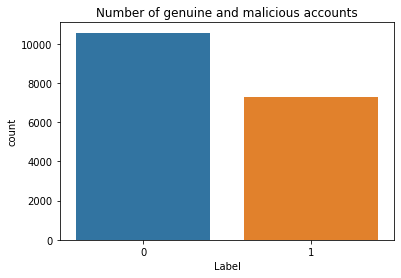

In [0]:
sns.countplot(train['result'])
plt.xlabel('Label')
plt.title('Number of genuine and malicious accounts')

# Balancing Dataset

In [0]:
new_train = train.groupby(['original_author', 'result'])['text'].apply(lambda x: '. '.join(x.astype(str))).reset_index()

In [0]:
# from copy import deepcopy

# new_train = deepcopy(train)

In [0]:
# Class count
count_class_0, count_class_1 = new_train.result.value_counts()

# Divide by class
df_class_0 = new_train[new_train['result'] == 0]
df_class_1 = new_train[new_train['result'] == 1]

In [0]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
new_train = pd.concat([df_class_0, df_class_1_over], axis=0)

In [0]:
new_train = new_train.sample(frac=1).reset_index(drop=True)

Text(0.5, 1.0, 'Number of genuine and malicious accounts')

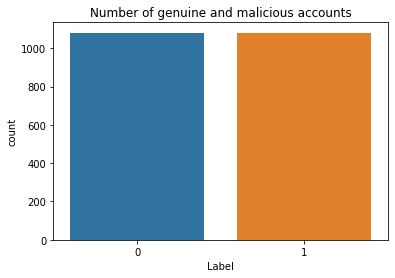

In [0]:
sns.countplot(new_train['result'])
plt.xlabel('Label')
plt.title('Number of genuine and malicious accounts')

In [0]:
len(new_train['text']), len(new_train['result'])

(2162, 2162)

# Preprocessing

In [0]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory 
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import string, re

def clean_text(text):
    text = re.findall('[A-Z][^A-Z]*', str(text)) #split hashtag
    text_lc = " ".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[^A-Za-z0-9 ]+', '', text_lc)
    text = stopword.remove(text_rc)

    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    return text

stopword = StopWordRemoverFactory().create_stop_word_remover()
# stemmer = StemmerFactory().create_stemmer()

new_train['text'] = new_train['text'].apply(lambda x: clean_text(x))
new_train['text'] = new_train['text'].apply(lambda x: ''.join([" " if ord(i) < 32 or ord(i) > 126 else i for i in x]))
new_train.head(10)

,original_author,result,text
0,herpjuna__,0,bengi iki rasane adem sepi mergo opo mergo cr...
1,AlfikroDzakiyah,1,wajarlah lha wong bonekanya kafir penjajah t...
2,_changeworld,0,biasa ajabaru main twitter lagisetelah sekian ...
3,ILHAM30097856,1,klo agar terjadi dinasti politik tidak setuju ...
4,FitrianiArifah,0,miring kanan mampet miring kiri mampet maunya...
5,Libra_Koto,1,putra erlangga siap gerakan blokir fadjroel ...
6,sayahiramatomu,1,ktvaxc diamankan hari pertama starwars the ri...
7,shalsihab,0,mau pakai apa aja sok penting sesuai sama temp...
8,barkahasabay,1,v hcrfp g terimakasih pos membantu memudahkan...
9,Aden_GD,1,wah slamat hari jadi banyuwangi smoga tetap i...


In [0]:
len(new_train['text'])

2162

# Tokenize and Padding

In [0]:
X, Y = new_train.text.fillna(' ').values, new_train.result.values.reshape(-1,1)

In [0]:
len(X), len(Y)

(2162, 2162)

In [0]:
num_words = 5000
maxlen = 150

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

vocab_size

35039

In [0]:
# FOR FILTERED DATA
X = tokenizer.texts_to_sequences(X)
X = sequence.pad_sequences(X, padding='post', maxlen=maxlen)

# Experimentation

In [0]:
# y_bin = keras.utils.to_categorical(Y, 2)

In [0]:
# y_bin

In [0]:
embedding_dim = 50

def RNN():
    inputs = Input(name='inputs',shape=[maxlen])
    layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    # layer = Dense(2, activation='softmax'))(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [0]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 150, 50)           1751950   
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_5 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

In [0]:
model.fit(X, Y, batch_size=128, epochs=100,
          validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)]) 

Train on 1729 samples, validate on 433 samples
Epoch 1/100
1729/1729 [==============================] - 5s 3ms/step - loss: 0.6933 - acc: 0.5026 - val_loss: 0.6919 - val_acc: 0.4804
Epoch 2/100
1729/1729 [==============================] - 4s 2ms/step - loss: 0.6908 - acc: 0.5055 - val_loss: 0.6856 - val_acc: 0.4804
Epoch 3/100
1729/1729 [==============================] - 3s 2ms/step - loss: 0.7418 - acc: 0.5379 - val_loss: 0.6631 - val_acc: 0.5681
Epoch 4/100
1729/1729 [==============================] - 3s 2ms/step - loss: 0.6568 - acc: 0.5645 - val_loss: 0.6501 - val_acc: 0.5935
Epoch 5/100
1729/1729 [==============================] - 3s 2ms/step - loss: 0.6491 - acc: 0.5836 - val_loss: 0.6558 - val_acc: 0.5843


# Evaluation

In [0]:
test['text']

0       krnagst Windipuspita yoongisce akaazs annemoon...
1       krnagst Windipuspita yoongisce akaazs annemoon...
2                                 euhrreka Aamiin aamiin🙏
3       Shiningcloudd Doa trbaik utk kk Gigi\n😇\nSemog...
4       Shiningcloudd Hai ka Gigi 🙋‍♀\nSemangat\nDan o...
                              ...                        
4463                              Ounch httpstcoaYXfrZqOF
4464    biasa aja soalnya gak ada emyu ðŸ˜” httpstcoYE...
4465                                Persekat ðŸ”¥ðŸ”¥ðŸ”¥
4466                                        GKRHayu Waduh
4467                                    unitedarmyfc Cupu
Name: text, Length: 4468, dtype: object

In [0]:
test = test.groupby(['original_author', 'result'])['text'].apply(lambda x: '. '.join(x.astype(str))).reset_index()

In [0]:
test['text'] = test['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: ''.join([" " if ord(i) < 32 or ord(i) > 126 else i for i in x]))
test.head()

,original_author,result,text
0,05Fhie,1,a fiestapoin tebakanmandiri viraaal done du...
1,19Muhamad,0,arie setia halikkuagit lamz fakboiidamanmu p...
2,20detik,0,scoopy kucing penjaga kunci kamar bone ht...
3,Aagim_,0,kampanglah tirto i d nyeri sendi psiid http...
4,Abangsantriker1,1,nabi al musthofa wujud persatuan umat bukti...


In [0]:
X_test, Y_test = test.text.fillna(' ').values, test.result.values.reshape(-1,1)

In [0]:
# y_test_bin = keras.utils.to_categorical(Y_test, 2)

In [0]:
# FOR FILTERED DATA
X_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(X_test, padding='post', maxlen=maxlen)

In [0]:
ev = model.evaluate(X_test, Y_test)
print ('Accuracy = ', ev[1])

463/463 [==============================] - 1s 3ms/step
Accuracy =  0.5874730022241951


In [0]:
y_test = ['bot' if i==0 else 'genuine' for i in Y_test]

In [0]:
pred = model.predict(X_test)

pred[pred>0.5] = 1 
pred[pred<=0.5]= 0

y_pred = ['bot' if i==0 else 'genuine' for i in pred]

labels = ['bot', 'genuine']
cm = confusion_matrix(y_test, y_pred, labels)
cm

array([[247,  16],
       [175,  25]])

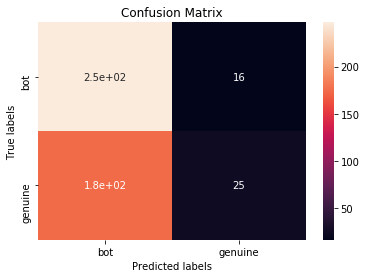

In [0]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['bot', 'genuine']); ax.yaxis.set_ticklabels(['bot', 'genuine']);

In [0]:
acc = accuracy_score(Y_test, pred)
prec = precision_score(Y_test, pred)
rec = recall_score(Y_test, pred)
f1 = f1_score(Y_test, pred)
roc = roc_auc_score(Y_test, pred)
print("Balanced Data")
print("Accuracy: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}\nF1 Score: {:.4f}\nROC/AUC Score: {:.4f}".format(acc, prec, rec, f1, roc))

Balanced Data
Accuracy: 0.5875
Precision: 0.6098
Recall: 0.1250
F1 Score: 0.2075
ROC/AUC Score: 0.5321


In [0]:
# result = zip(Y_test, ypred)

In [0]:
# sv = pd.DataFrame(ypred)

In [0]:
# sv.to_csv(BASE_DIR + 'tweet_only/output.csv')